In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath

In [2]:
%matplotlib notebook
fontsize = 14
color = 'k'
linewidth = 4
markersize = 10
margin = 0.2

# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
angle_unit = 'radian'

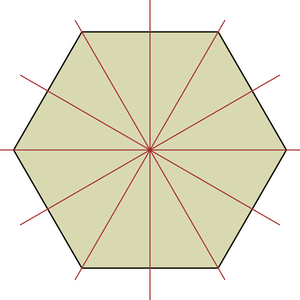

In [3]:
# Defining properties of the crystal and the box it's in

# Some key parameters
L = AssignQuantity(30,distance_unit)
npts_theta = 8
npts_r = 35
r_far_field = L*1.2

<IPython.core.display.Javascript object>


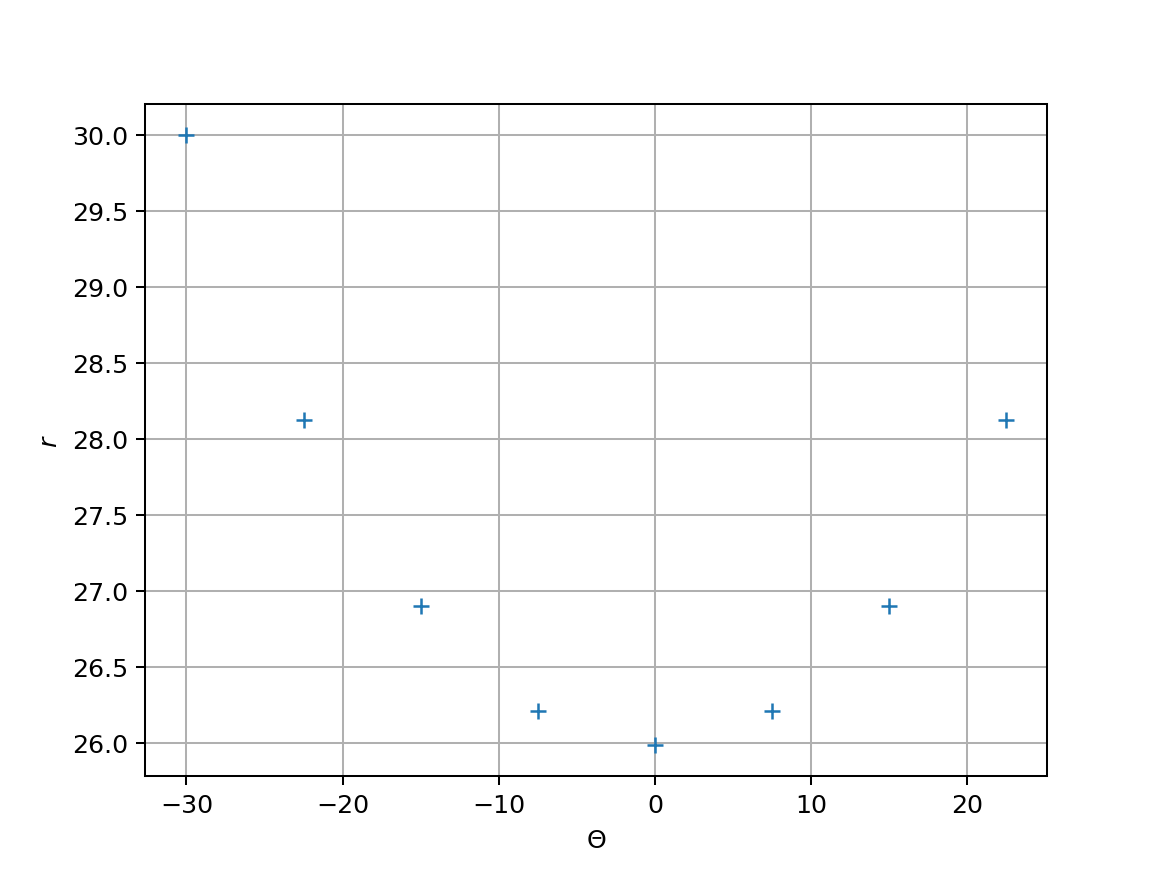

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


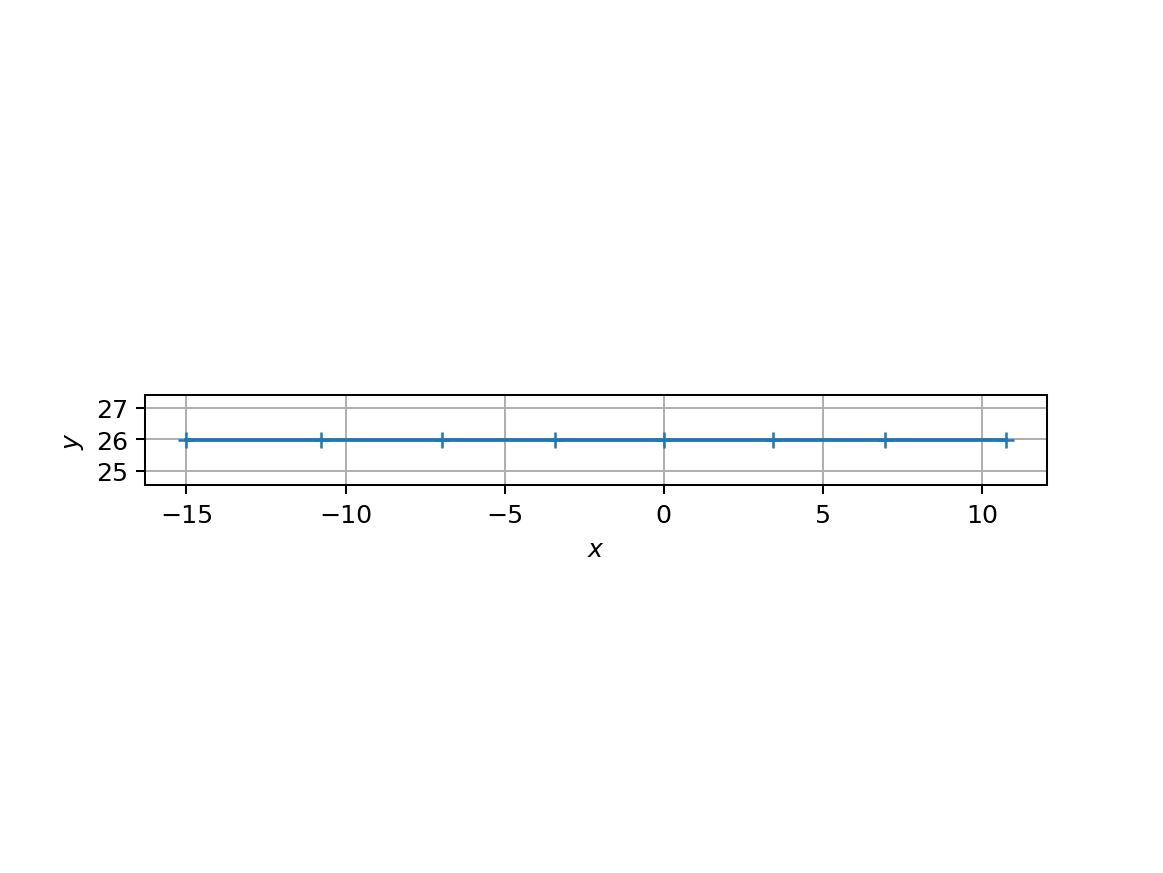

<IPython.core.display.Javascript object>


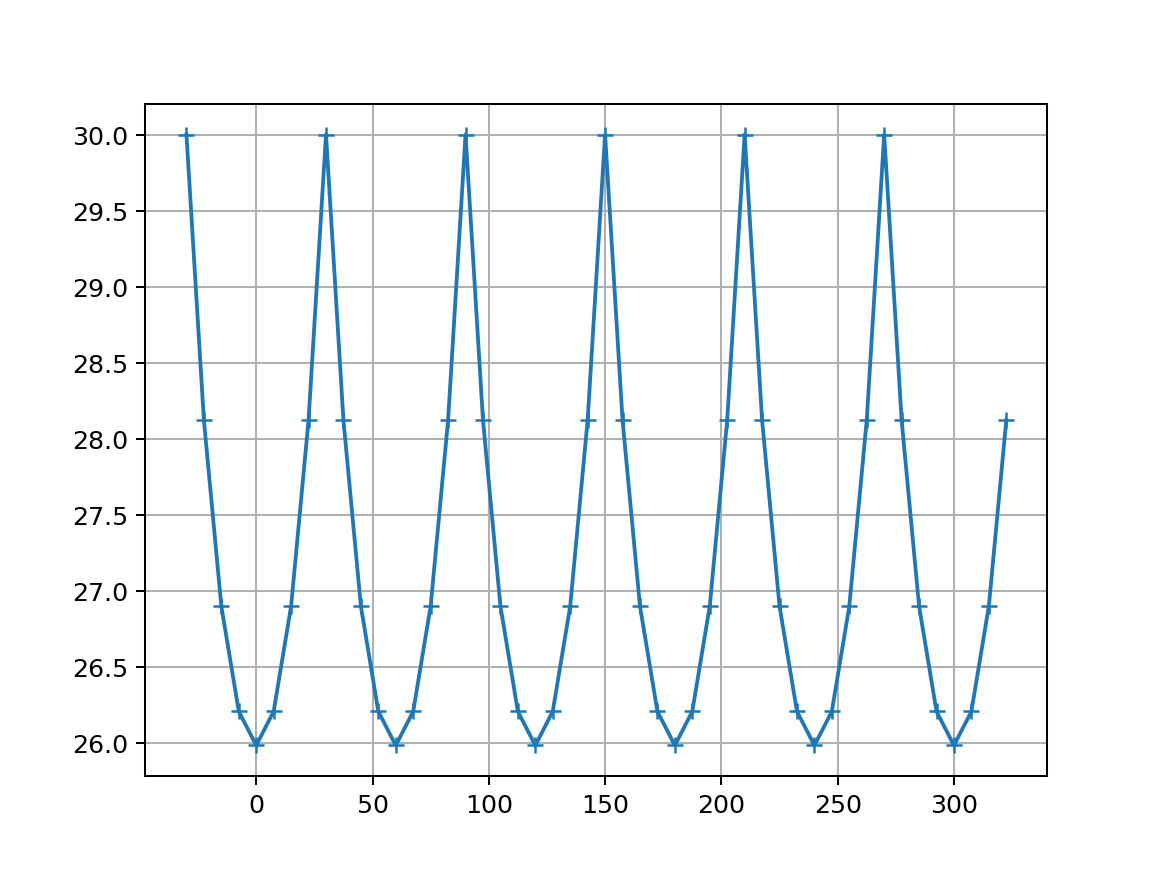

(48,)
(48,)


In [4]:
# Making the crystal

# Make the top edge of the crystal
angle = AssignQuantity(30, 'degree')
angle.ito(angle_unit)
y0 =L*np.cos(angle)
edge0_theta_complete = np.linspace(-angle,angle,npts_theta+1)
edge0_theta = edge0_theta_complete[0:-1]
dtheta = edge0_theta[1]-edge0_theta[0]
edge0_r = y0/np.cos(edge0_theta)
fig, ax = plt.subplots()
plt.plot(edge0_theta.to('degree'),edge0_r,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')
plt.grid(True)

# Convert to Cartesian to make sure this is a straight line at the right place
edge0_x = edge0_r*np.sin(edge0_theta)
edge0_y = edge0_r*np.cos(edge0_theta)
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0_x,edge0_y,'+-')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)

# Gather all the edges together as one big array
edges_theta = np.hstack([\
        edge0_theta,
        edge0_theta+2*angle,
        edge0_theta+4*angle,
        edge0_theta+6*angle,
        edge0_theta+8*angle,
        edge0_theta+10*angle])
edges_r = np.hstack([\
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r])
edges_r = AssignQuantity(edges_r,distance_unit)
edges_theta = AssignQuantity(edges_theta,angle_unit)
fig, ax = plt.subplots()
print(np.shape(edges_theta.to('degree').magnitude))
print(np.shape(edges_r.magnitude))
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'+-')
plt.grid(True)

36.0 micrometer
dr = 0.29468346724902617 micrometer


<IPython.core.display.Javascript object>


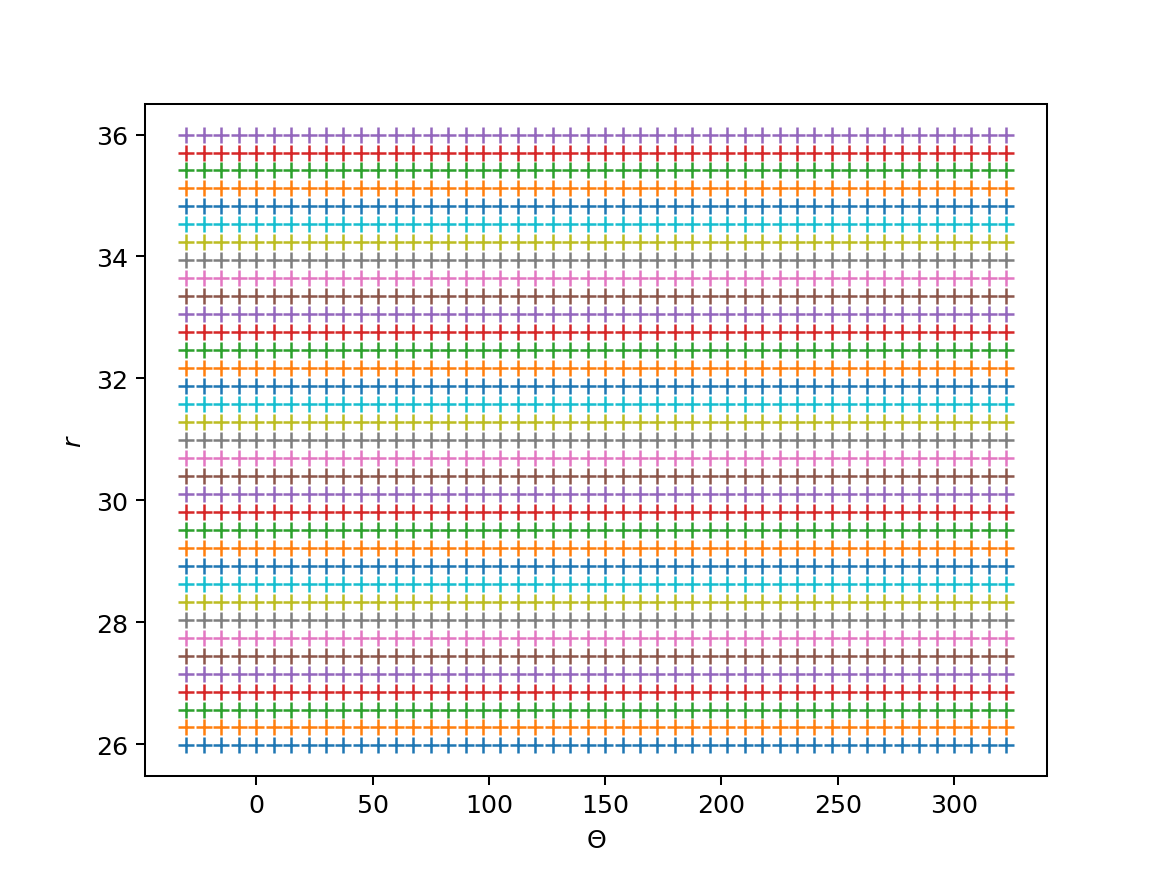

(48, 35)
(48, 35)


<IPython.core.display.Javascript object>


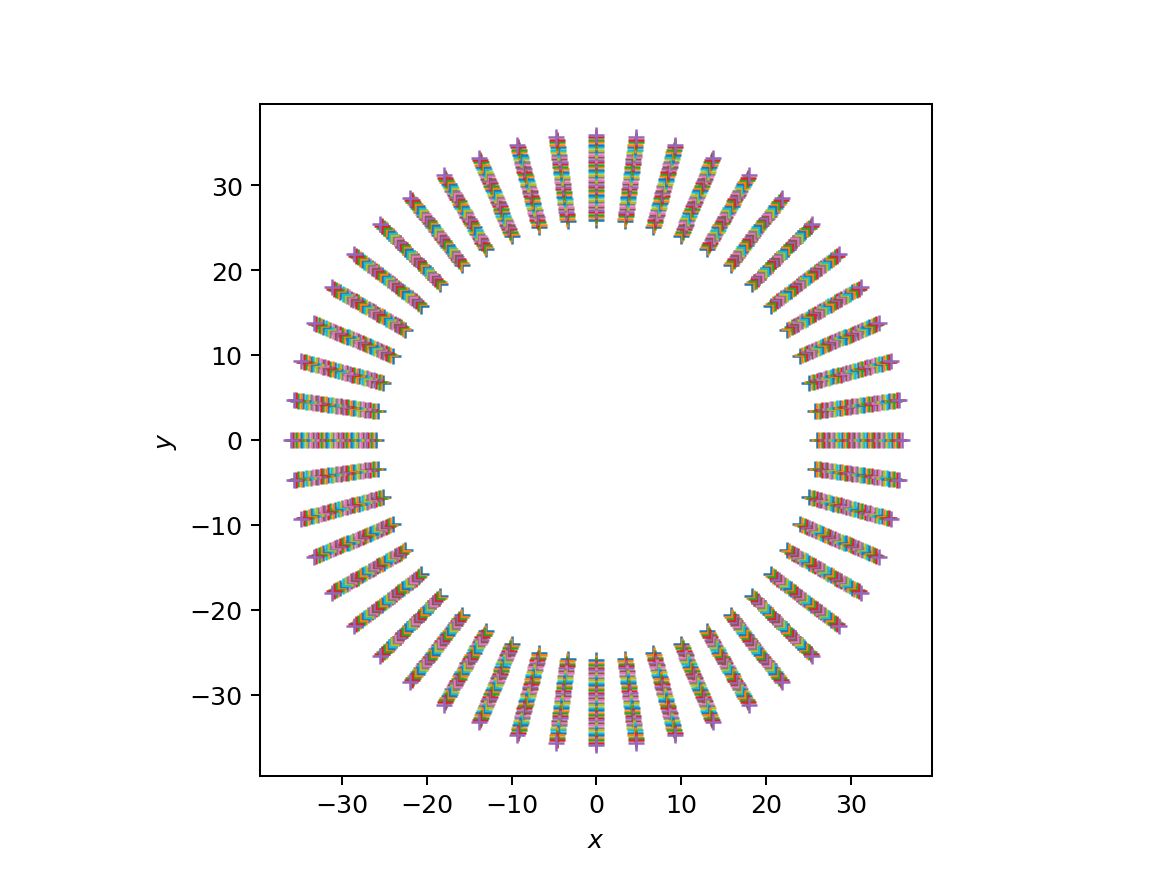

Text(0, 0.5, '$y$')

In [5]:
# Making a discretized box to put the crystal into (we'll use the crystal's angles)
rmin = np.min(edges_r); #print(rmin)
rmax = r_far_field; print(rmax)
array_r = np.linspace(rmin,rmax,npts_r)
dr = array_r[1]-array_r[0]; print('dr =', dr)
array_theta = edges_theta
grid_r, grid_theta = np.meshgrid(array_r.magnitude,array_theta.magnitude)
grid_r = AssignQuantity(grid_r,distance_unit)
grid_theta = AssignQuantity(grid_theta,angle_unit)
# print('r-values: ', grid_r[0,:])
# print('theta-values = ', grid_theta[:,0]*180/np.pi)
plt.figure()
plt.plot(grid_theta.to('degree').magnitude,grid_r.magnitude,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

# Converting to Cartesian to see what this looks like
# grid_x = array_r*np.sin(grid_theta)
# grid_y = array_r*np.cos(grid_theta)
grid_x = grid_r*np.sin(grid_theta); print(np.shape(grid_x))
grid_y = grid_r*np.cos(grid_theta); print(np.shape(grid_y))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(grid_x.magnitude,grid_y.magnitude,'+')
plt.xlabel('$x$')
plt.ylabel('$y$')

In [6]:
# Physical parameters

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.3

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('D = ', D)

# Growth rate
g_ice = AssignQuantity(1,'micrometer/second')

# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  11.802536421464435 micrometer / second
D0 =  21.893732126411837
D =  34908.31943863489 micrometer ** 2 / microsecond


In [7]:
# Time step, boundary conditions, etc.

# Getting a suitable time step
dt = dr**2/D/4; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
D_times_dt = D*dt; print('D_times_dt = ', D_times_dt)
Dthetaeff = D*dt/dtheta**2/L**2; print('Dthetaeff = ', Dthetaeff)

# kappa (need to check if this is right)
kappa = rho_ice*g_ice*R*Temp/(Mvap*dr); kappa.ito(pressure_unit+'/'+time_unit)

# Neumann
uneumann = kappa*dt
uneumann_mag = uneumann.magnitude

# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Equilibrium vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

dt =  6.219029393735242e-07 microsecond
D_times_dt =  0.02170958646747697 micrometer ** 2
Dthetaeff =  0.0014077702382530857 / radian ** 2
sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Equilibrium vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [8]:
# Index <--> position interconversion functions

def r_to_ir(r,array_r):
    dr = array_r[1]-array_r[0]
    ir = np.rint((r-array_r[0])/dr).astype(int)
    return ir
r_test = AssignQuantity(107, distance_unit)
ir_test = r_to_ir(r_test, array_r)
print(ir_test)

def ir_to_r(ir_test,array_r):
    dr = array_r[1]-array_r[0]
    r = ir_test*dr+array_r[0]
    return r
r_test2 = ir_to_r(ir_test, array_r)
print('r_test2', r_test2)
print('r Differences ... ', r_test2-r_test)

def theta_to_itheta(theta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    itheta = np.rint((theta-array_theta[0])/dtheta).astype(int)
    return itheta
theta_test = AssignQuantity(-32, 'degree')
itheta_test = theta_to_itheta(theta_test.to(angle_unit), array_theta)
print(itheta_test)

def itheta_to_theta(itheta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    theta = itheta*dtheta+array_theta[0]
    return(theta)
theta_test2 = itheta_to_theta(itheta_test, array_theta)
print('theta_test2', theta_test2)
print('theta Differences ... ', theta_test2-theta_test)

275 dimensionless
r_test2 107.01871560701535 micrometer
r Differences ...  0.01871560701535202 micrometer
0 dimensionless
theta_test2 -0.5235987755982988 radian
theta Differences ...  0.03490658503988664 radian


<IPython.core.display.Javascript object>


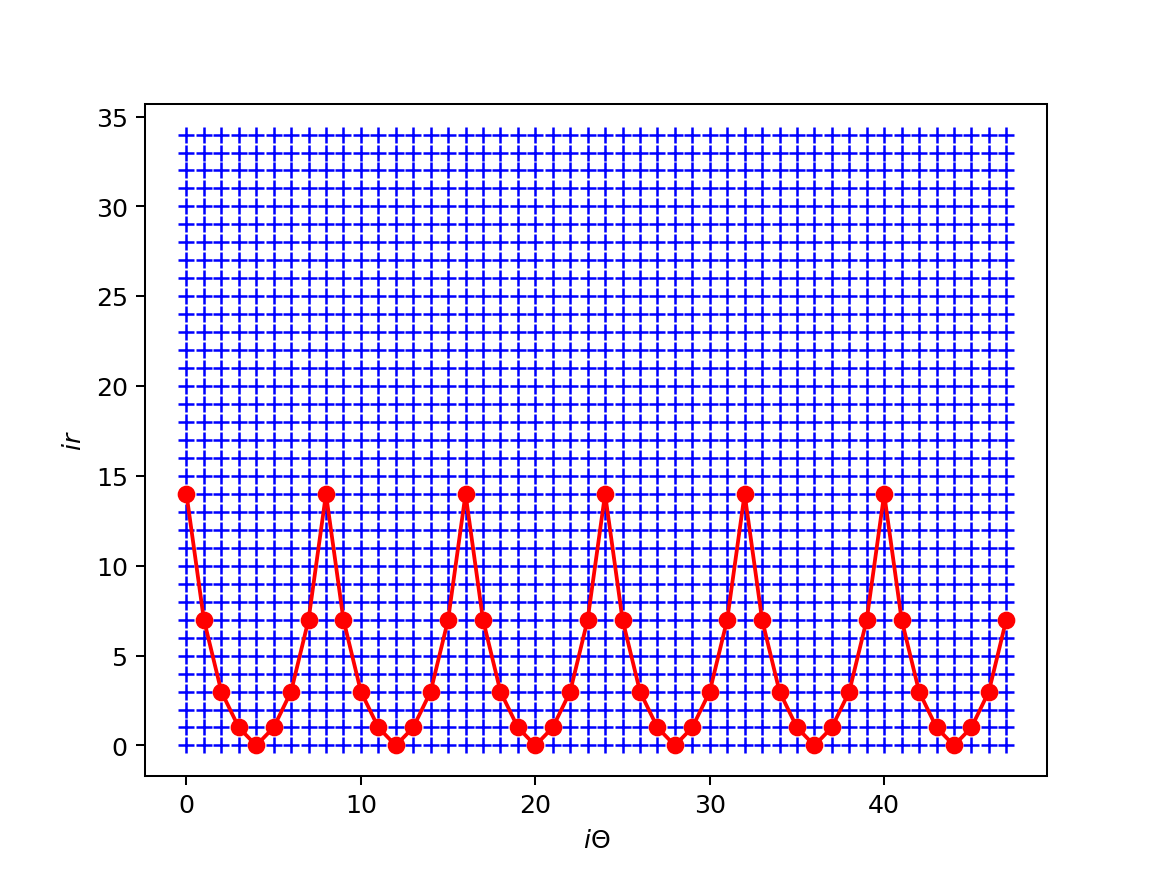

<IPython.core.display.Javascript object>


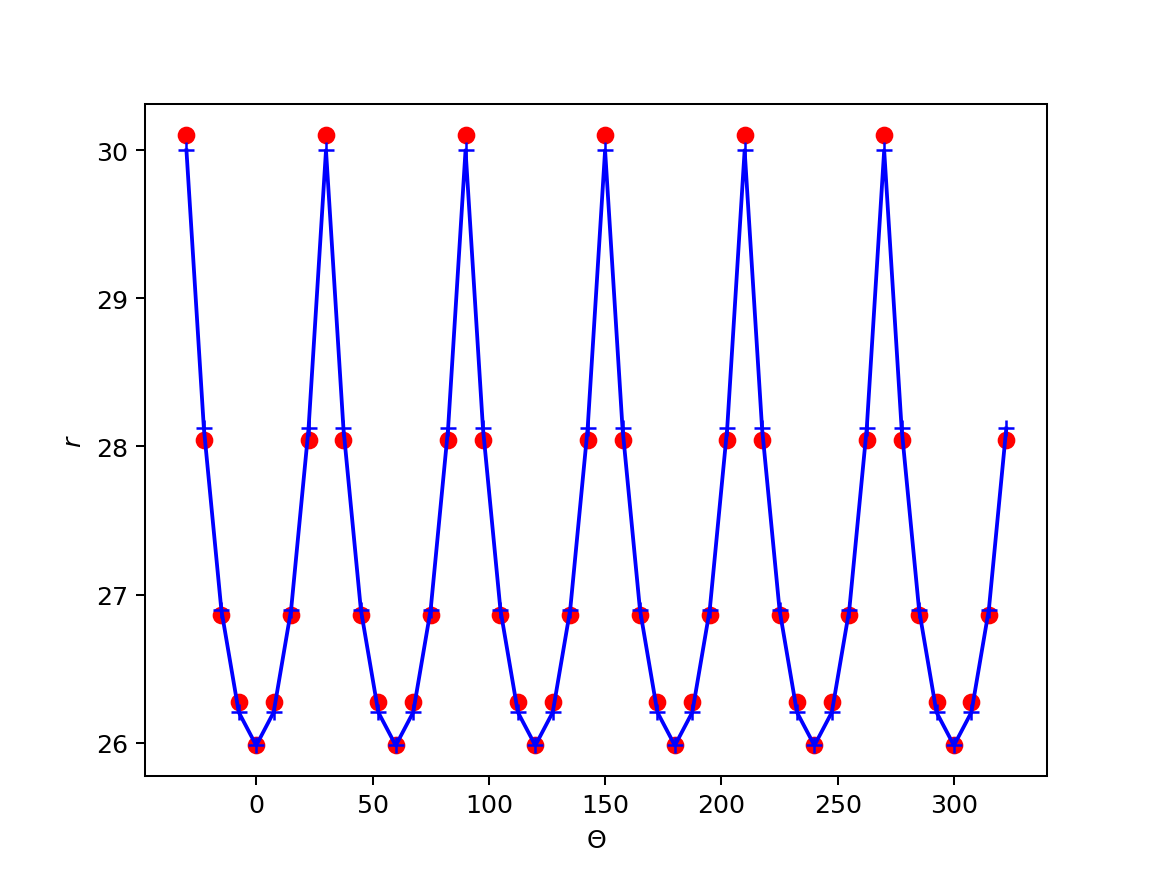

Text(0, 0.5, '$r$')

In [9]:
# Plotting the crystal edge in index space
edges_ir = r_to_ir(edges_r,array_r)
edges_itheta = theta_to_itheta(edges_theta, array_theta)

igrid_r = r_to_ir(grid_r,array_r)
igrid_theta = theta_to_itheta(grid_theta, array_theta)

plt.figure()
plt.plot(igrid_theta,igrid_r,'+b')
plt.plot(edges_itheta.magnitude,edges_ir.magnitude,'ro-')
plt.xlabel('$i\Theta$')
plt.ylabel('$ir$')

edges_r2 = ir_to_r(edges_ir, array_r)
edges_theta2 = itheta_to_theta(edges_itheta, array_theta)

plt.figure()
plt.plot(edges_theta2.to('degree'),edges_r2,'ro')
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'b+-')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

### Progress
The cells below are "in progress"

In [10]:
def Polar_propagate_hexagon(u0, udirichlet, uneumann, Dreff2, Dreff1, edges_ir, edges_itheta,array_r):

    # Propagates the vapor field forward one time step
    
    # Initialize starting values
    un = np.zeros(np.shape(u0))

    # Diffusion in the radial direction
    npts_edge = len(edges_itheta)
    for itheta in range(npts_edge):
        
        # Radial indices for the adjacent surface (ir) and the two farther out
        ir = edges_ir[itheta]
        ir_plus1 = ir+1
        ir_plus2 = ir+2
        
        # These assignments are for one pixel beyond the adjacent surface, out to the far field
        un[itheta,ir_plus1:-1] = u0[itheta,ir_plus1:-1] +\
            (u0[itheta,ir_plus2:] - 2*u0[itheta,ir_plus1:-1] +u0[itheta,ir:-2])*Dreff2 +\
            (u0[itheta,ir_plus2:]   - u0[itheta,ir_plus1:-1])                  *Dreff1/array_r[ir_plus1:-1]
        
        # This assignment is for the adjacent pixel 
        un[itheta,ir] = u0[itheta,ir] +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff2 +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff1/array_r[ir]
        
        # Still need the 3rd part of the Laplacian (second derivative with respect to theta)
        
        
    # Assigning Dirichlet conditions at the far-field limit
    un[:,-1] = udirichlet
    
    # Assigning Neumann conditions above the crystal surface
    for i in range(npts_edge):
        un[edges_itheta[i],edges_ir[i]] -= uneumann
            
    return(un)

In [11]:
# Decide on a time to propagate forward
tmax = AssignQuantity(.05,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above
Dreff2 = (D_times_dt / dr**2)
Dreff1 = (D_times_dt / dr)

# Propagate forward in time
un = np.zeros(np.shape(igrid_r))
un[:,-1] = udirichlet.magnitude
for i in range(ntimes):
    un = Polar_propagate_hexagon(\
        un, udirichlet.magnitude, uneumann.magnitude, Dreff2.magnitude, Dreff1.magnitude, \
        edges_ir.magnitude, edges_itheta.magnitude, array_r.magnitude)

Integrating steps =  80398
Integrating out to  0.0499997525197526 microsecond


0.0
38.41530351858555


<IPython.core.display.Javascript object>


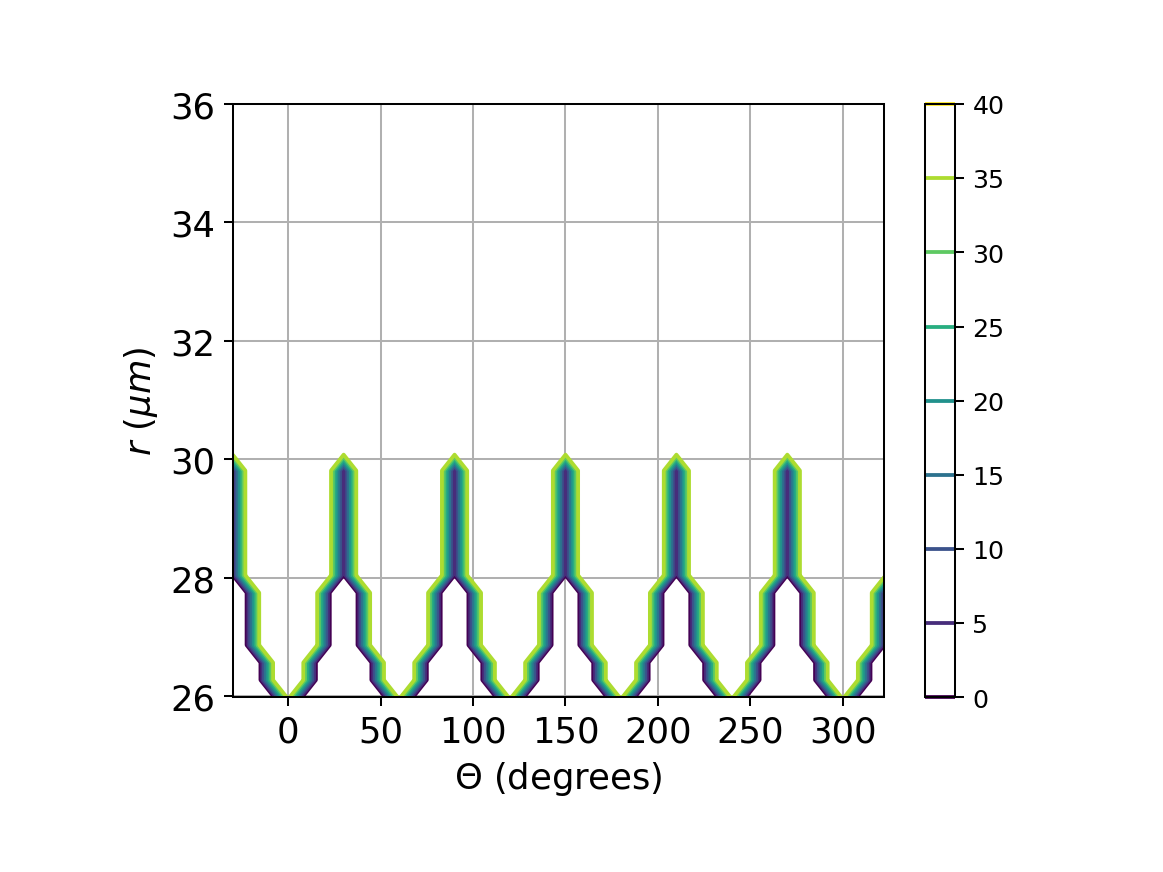

In [12]:
# Graph as contour plot in theta,r space
un1 = un[0,4]; print(un1)
un2 = udirichlet.magnitude; print(un2)
nlevels = 10
levels = np.linspace(un1,un2,nlevels)
fig,ax = plt.subplots()
# CS = ax.contour(array_theta.to('degree').magnitude,array_r.magnitude,un.T,levels)
CS = ax.contour(array_theta.to('degree').magnitude,array_r.magnitude,un.T)
ax.set_xlabel('$\Theta$ (degrees)', fontsize=fontsize)
ax.set_ylabel('$r$ ($\mu m$)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
plt.grid(True)
fig.colorbar(CS)

<IPython.core.display.Javascript object>


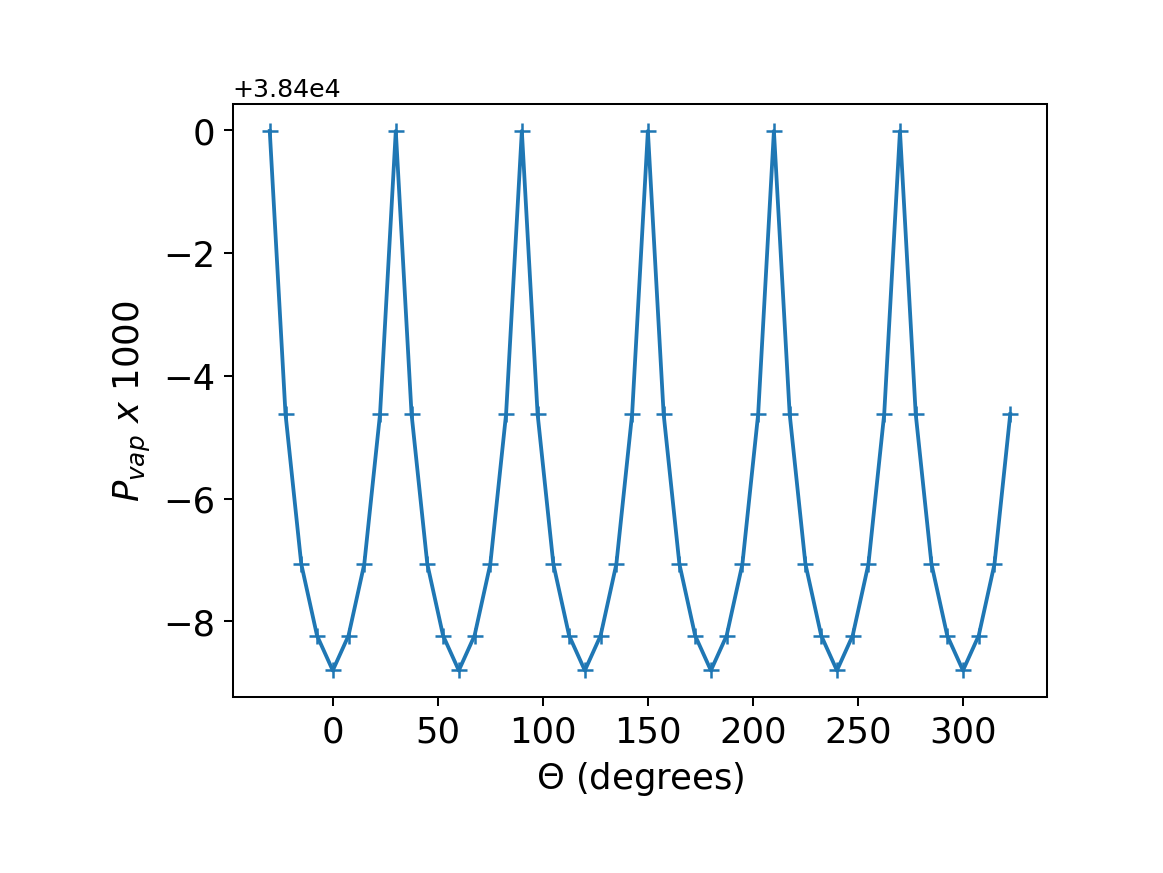

In [29]:
# Graph vapor pressure at the adjacent surface (ir)
npts_edge = len(edges_itheta)
Pvap_edge = np.zeros(npts_edge)
for itheta in range(npts_edge):
    ir = edges_ir[itheta].magnitude
    Pvap_edge[itheta] = un[itheta,ir]*1e3

plt.figure()
plt.plot(array_theta.to('degree').magnitude,Pvap_edge,'+-')
plt.xlabel('$\Theta$ (degrees)', fontsize=fontsize)
plt.ylabel('$P_{vap} \  x \ 1000$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 

In [14]:
# # Making a paired list of the crystal edge indices (may not need this)
# edges = []
# for i in range (len(edges_theta)):
#     edges.append([edges_theta.to('degree')[i].magnitude, edges_r[i].magnitude])
# edges = np.array(edges)
# print(edges)

# iedges = []
# for i in range (len(edges_itheta)):
#     iedges.append([edges_itheta[i].magnitude, edges_ir[i].magnitude])
# iedges = np.array(iedges)
# print('iedges', iedges)

In [15]:
# # Graph as contour plot in Cartesian space
# # fig,ax = plt.subplots()
# # CS = ax.contour(grid_x.magnitude,grid_y.magnitude,un.T,levels)
# from scipy.interpolate import LinearNDInterpolator
# interp = LinearNDInterpolator(list(zip(grid_x.magnitude, grid_y.magnitude)), un)

In [16]:
# # Calculating the diffusion coefficient matrix, with zeros for in and around the crystal
# Dmatrix = np.ones((nx-1,ny-1))*Deff.magnitude
# nx_D, ny_D = np.shape(Dmatrix)
# print(nx_D, ny_D)
# for i in range(n_inside_unique):
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i]-1,i_inside_unique[1,i]] = 0
# #     Dmatrix[i_inside_unique[0,i]+1,i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]-1] = 0
# #     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]+1] = 0

# # Checking    
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.plot(ix_inside_unique,iy_inside_unique,'x')
# for ix in range(nx_D):
#     for iy in range(ny_D):
#         if Dmatrix[ix,iy] != 0:
#             plt.plot(ix,iy,'+g',)

In [17]:
# # Getting indices of pixels inside the crystal
# iedges_unique_float = iedges_unique.astype(float)
# polygon = iedges_unique_float.T
# path = mpltPath.Path(polygon); #print(path)
# ix_inside = []
# iy_inside = []
# for ix in range(nx):
#     for iy in range(ny):
#         inside = path.contains_points([[ix,iy]])
#         if inside:
#             ix_inside.append(ix)
#             iy_inside.append(iy)
# i_inside = np.vstack((ix_inside,iy_inside))
# i_inside_unique, n_inside_unique = VFD.removedups2(i_inside,iedges_unique)
# ix_inside_unique = i_inside_unique[0,:]
# iy_inside_unique = i_inside_unique[1,:]
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# for i in range(npts_unique):
#     plt.plot(iedges_unique[0,i],iedges_unique[1,i],'+g')
# plt.plot(ix_inside_unique,iy_inside_unique,'x')

In [18]:
# # Checking to make sure the indexed positions are not too far off
# xedges_again = VFD.Cartesian_index_to_position(ixedges,Lbox_x,dedge)
# yedges_again = VFD.Cartesian_index_to_position(iyedges,Lbox_y,dedge)
# edges_again = np.vstack((xedges_again,yedges_again))
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.plot(edges[0,:],edges[1,:],'bx',label='original')
# plt.plot(edges_again[0,:],edges_again[1,:],'go',label='from indices')
# plt.grid(True)
# plt.title('Comparison of actual positions')
# plt.legend()

In [19]:
# # Calculating the diffusion coefficient matrix, with zeros for in and around the crystal
# Dmatrix = np.ones((nx-1,ny-1))*Deff.magnitude
# nx_D, ny_D = np.shape(Dmatrix)
# print(nx_D, ny_D)
# for i in range(n_inside_unique):
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i]-1,i_inside_unique[1,i]] = 0
# #     Dmatrix[i_inside_unique[0,i]+1,i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]-1] = 0
# #     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]+1] = 0

# # Checking    
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.plot(ix_inside_unique,iy_inside_unique,'x')
# for ix in range(nx_D):
#     for iy in range(ny_D):
#         if Dmatrix[ix,iy] != 0:
#             plt.plot(ix,iy,'+g',)

In [20]:
# # Calculating the dirichlet conditions at the far-field boundary as supersaturations
# sigmaII_far_field = sigmaI_far_field - sigma0
# print('sigmaI_far_field = ', sigmaI_far_field)
# print('sigmaII_far_field = ', sigmaII_far_field)

# # Converting supersaturations into pressures
# P3 = AssignQuantity(611,'Pa')
# T3 = AssignQuantity(273,'kelvin')
# Delta_H_sub = AssignQuantity(50,'kJ/mol')
# P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)
# udirichlet = P_vapor_eq*(sigmaI_far_field+1)
# print('udirichlet = ', udirichlet)

In [21]:
# def propagate_hexagon(u0,udirichlet,uneumann,Deff,Dmatrix,iedges,npts_total):

#     # Propagates the vapor field forward one time step
    
#     # Initialize starting values
#     un = np.zeros(np.shape(u0))

#     # Diffusion throughout (this is wrong)
#     un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
#     ( (u0[2:, 1:-1] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[0:-2, 1:-1] -u0[1:-1, 1:-1])*Dmatrix[0:-1,1:] ) + \
#     ( (u0[1:-1, 2:] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[1:-1, 0:-2] -u0[1:-1, 1:-1])*Dmatrix[1:,0:-1] ) )
    
#     # Assigning Dirichlet conditions at the perimeter of the simulation box
#     un[[0,-1],:] = udirichlet
#     un[:,[0,-1]] = udirichlet
    
#     # Assigning Neumann conditions above the crystal surface
#     for i in range(npts_total):
#         un[iedges[0,i],iedges[1,i]] -= uneumann
            
#     return(un)

In [22]:
# # Decide on a time to propagate forward
# tmax = AssignQuantity(1,time_unit)
# ntimes = int(tmax/dt)
# print('Integrating steps = ', ntimes)
# print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above

# # Propagate forward in time
# un = np.zeros(np.shape(xgrid))
# for i in range(ntimes):
#     un = VFD.Cartesian_propagate_hexagon(\
#         un,udirichlet.magnitude,uneumann.magnitude,Deff.magnitude,Dmatrix,\
#         iedges, npts_total)

In [23]:
# # Specifying larger fonts, etc.
# fontsize = 15
# margin = 0.25

# # Select some points to help with contouring and slicing
# ixmid = VFD.Cartesian_position_to_index(0,Lbox_x,dedge); print(ixmid)
# iymid = VFD.Cartesian_position_to_index(0,Lbox_y,dedge); print(iymid)
# iyabove = VFD.Cartesian_position_to_index(y0,Lbox_y,dedge); print(iyabove)
# iybelow = VFD.Cartesian_position_to_index(-y0,Lbox_y,dedge); print(iybelow)

# # Graph as contour plot
# un1 = un[ixmid,iyabove]
# un2 = udirichlet_mag
# nlevels = 8
# levels = np.linspace(un1,un2,nlevels)
# fig,ax = plt.subplots()
# ax.set_aspect('equal')
# CS = ax.contour(xarray,yarray,un.T,levels)
# ax.set_xlabel('$x$ ($\mu m$)', fontsize=fontsize)
# ax.set_ylabel('$y$ ($\mu m$)', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.subplots_adjust(bottom=margin)
# plt.grid(True)
# # fig.colorbar(CS)
# plt.plot(edges_again[0,:],edges_again[1,:],'o')

# # Horizontal slice that goes across a crystal face
# fig,ax = plt.subplots()
# sigma_percent = (un[:,iyabove]/P_vapor_eq.magnitude-1)*100
# plt.plot(xarray,sigma_percent)
# plt.grid(True)
# plt.xlim(-L/2,L/2)
# VFD.autoscale(ax, 'y')
# plt.xlabel('$x$ ($\mu m$)', fontsize=fontsize)
# plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.subplots_adjust(bottom=margin) 
# plt.subplots_adjust(left=margin) 
# plt.title('above top of the crystal')
# c_r_percent = (np.max(un[:,iyabove])-np.min(un[:,iyabove]))/np.max(un[:,iyabove])*100
# print('c_r(%) =', c_r_percent)

# # Horizontal slice that goes across all the crystal faces
# fig,ax = plt.subplots()
# sigma_percent = (un[ixedges,iyedges]/P_vapor_eq.magnitude-1)*100
# distance_around = np.linspace(0,L*6,npts_total)
# plt.plot(distance_around,sigma_percent)
# plt.grid(True)
# plt.xlabel('$d$ ($\mu m$)', fontsize=fontsize)
# plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.subplots_adjust(bottom=margin) 
# plt.subplots_adjust(left=margin) 

# # Horizontal slices that go through the crystal to make sure Pvap -> 0 inside
# plt.figure()
# plt.plot(xarray,un[:,iymid],'b-+',label='middle')
# plt.plot(xarray,un[:,iyabove-1],label='top of crystal')
# plt.plot(xarray,un[:,iybelow+1],label='bottom of crystal')
# plt.grid(True)
# plt.xlabel('x')
# plt.legend()